In [33]:
PROCESSES_COUNT = 10

print("Importing...")
from multiprocessing import Pool

import importlib
import os
import sys
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools, plot_tools, data_tools, endf_tools, komodo_tools
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from progressbar import progressbar
from tqdm import tqdm
from uncertainties import ufloat

importlib.reload(komodo_tools)

results = []

result_folders = run_tools.get_all_result_dirs()
print(f"Found {len(result_folders)} result folders")

def handle_folder(result_folder):
    result_path = f"../results/{result_folder}"
    run_settings = run_tools.load_run_settings_json(result_path)

    result = { 
        "result_path": result_path
    }

    # Load the KOMODO result
    komodo_result = komodo_tools.get_komodo_result(result_path, komodo_input_file=run_settings["komodo_input_file"])
    if komodo_result is None:
        return None

    result.update(run_settings)
    result.update(komodo_result)
    
    return result

print(f"Loading data with {PROCESSES_COUNT} processes...")
with Pool(PROCESSES_COUNT) as p:
    # Loop over each run number and get the run settings as well as the k-effective
    # for result_folder in tqdm(result_folders):
    results = list(tqdm(p.imap(handle_folder, result_folders), total=len(result_folders)))

# Remove any results that failed
results = [result for result in results if result is not None]

Importing...
Found 92 result folders
Loading data with 10 processes...


100%|██████████| 92/92 [00:00<00:00, 2463.83it/s]


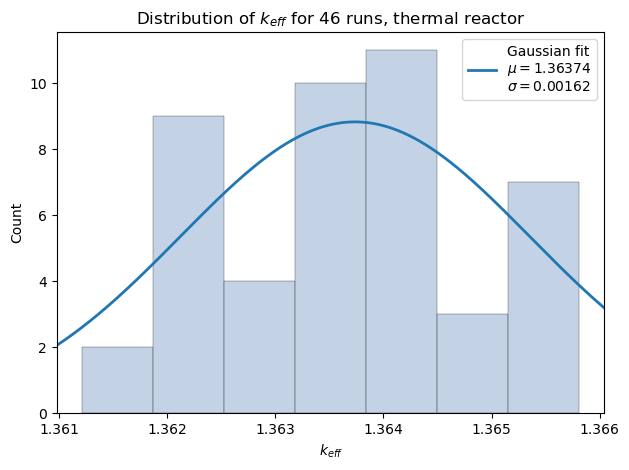

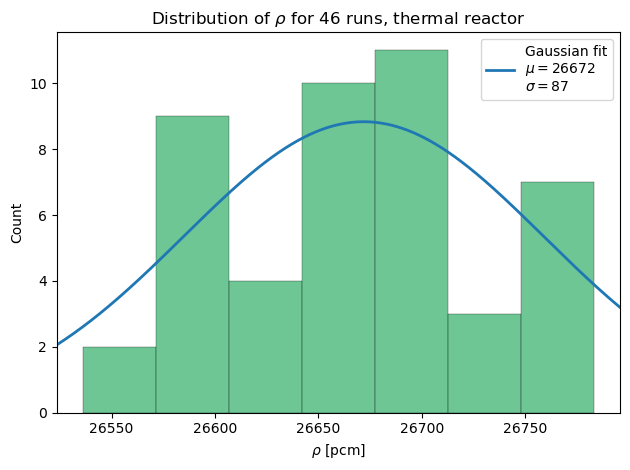

In [34]:
importlib.reload(plot_tools)
importlib.reload(data_tools)
importlib.reload(komodo_tools)

# PLOT SETTINGS:
for FAST_REACTOR in [True, False]:
    plt.close("all")

    NEUTRON_TEMP = "EPITHERMAL" if FAST_REACTOR else "THERMAL"

    folder_name = f"plots-{NEUTRON_TEMP}"
    os.makedirs(folder_name, exist_ok=True)

    def get_filename(plot_type: str, value: str):
        return f"{folder_name}/{plot_type}_{value}-{NEUTRON_TEMP}.pdf"

    # Create a dataframe from the results
    df = pd.DataFrame(results)

    # Filters
    df = df[df["fast_reactor"] == FAST_REACTOR]

    if df.empty:
        print(f"WARN: No results found for {NEUTRON_TEMP} reactor")
        break

    df = data_tools.add_reactivity_to_df(df, include_std=False)

    plt.figure()
    fig, popt, pcov = plot_tools.plot_histogram_from_df(df=df, data_key="k-eff", 
                                            fit_gaussian=True, decimals=5,
                                            title=f"Distribution of $k_{{eff}}$ for {len(df)} runs, {NEUTRON_TEMP.lower()} reactor", x_label="$k_{eff}$", y_label="Count",
                                            filename=get_filename("heatmap", "distribution-k_eff"))

    plt.figure()
    fig, popt, pcov = plot_tools.plot_histogram_from_df(df=df, data_key="rho-pcm", color="mediumseagreen",
                                            fit_gaussian=True, decimals=0,
                                            title=fr"Distribution of $\rho$ for {len(df)} runs, {NEUTRON_TEMP.lower()} reactor", x_label=r"$\rho$ [pcm]", y_label="Count",
                                            filename=get_filename("heatmap", "distribution-rho"))